# Analisando as características de transações desse e-commerce

In [1]:
import pandas as pd
import numpy as np
import os, sys
import datetime as dt
from datetime import datetime

sys.path.insert(0, os.path.abspath(".."))
from src import utils as ult
from dotenv import load_dotenv ; load_dotenv()

# Importando plot functions
from src import plot_utils as plu

# Desligando warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Coleta o path_start, basicamente o local da pasta onde estão os dados.
path_start = os.getenv("PATH_START")
df = pd.read_csv(f"{path_start}data\\silver_dados_stone.csv")
df.drop(['Unnamed: 0'],axis=1, inplace=True) ; df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11128 entries, 0 to 11127
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dia     11128 non-null  object 
 1   Hora    11128 non-null  object 
 2   Valor   11128 non-null  float64
 3   Cartão  11128 non-null  object 
 4   CBK     11128 non-null  object 
dtypes: float64(1), object(4)
memory usage: 434.8+ KB


### Quais são as características gerais desse e-commerce?

In [3]:
plu.calculate_statistics(df=df)

##################################################################################
O total de revenue em risco devido a cbk é 104847.86
A taxa de risco de cbk desse e-commerce é 7.27%
O revenue garantido desse e-commerce no mes de maio é 1336785.39
CBK Rate desse e-commerce 5.14%
Qtd de operações de CBK 572
##################################################################################


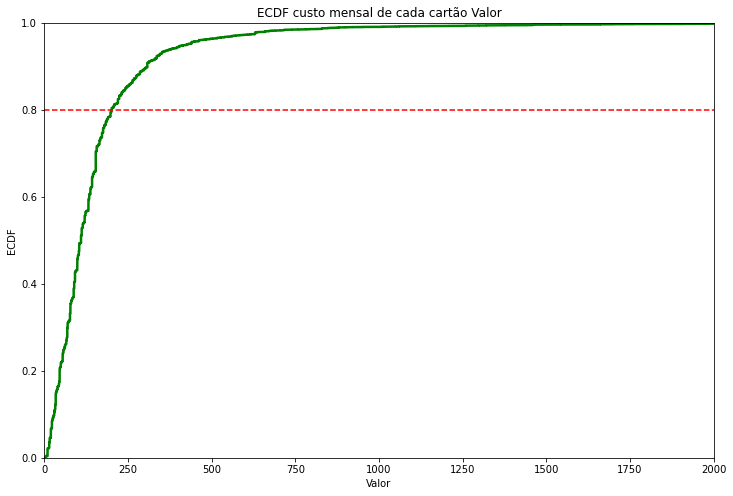

In [4]:
plu.plot_ecdf_geral(
    df=df.groupby(['Cartão'])['Valor'].sum().reset_index(),
    col='Valor'
)

Q1: 59.99 | Mediana: 110.0 | Q3: 176.0


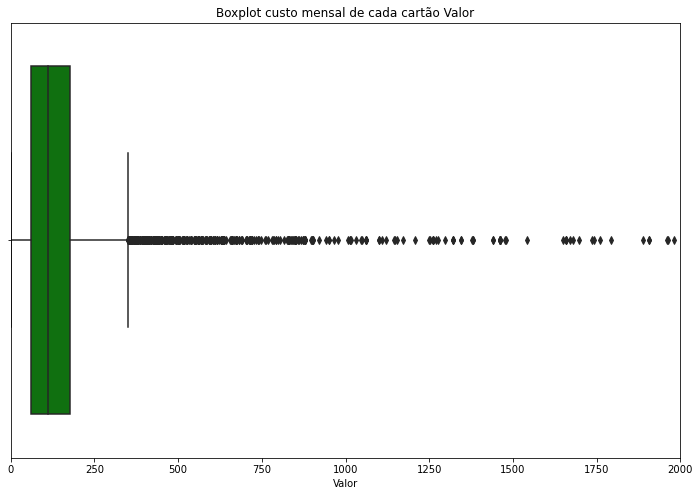

In [5]:
plu.plot_box_plot(
    df=df.groupby(['Cartão'])['Valor'].sum().reset_index(),
    col='Valor'
)

In [6]:
plu.calculate_ticket_medio(df=df)

########################################################################
O ticket médio por operação é 129.5500763838965 com uma desvio padrão 141.4205536785047
########################################################################


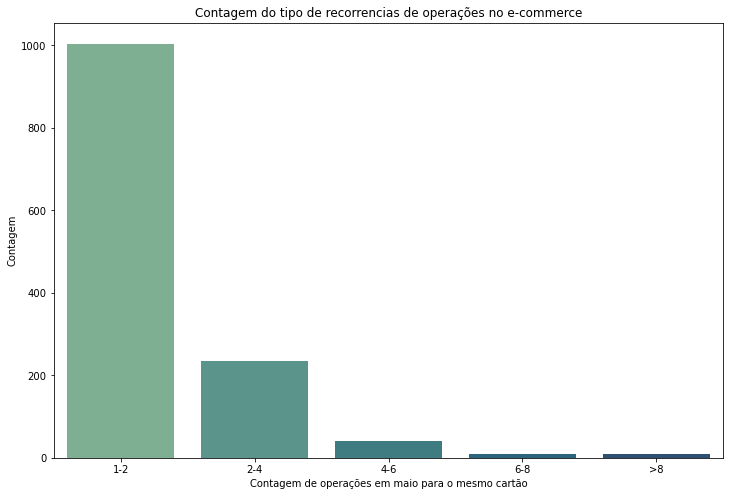

In [7]:
plu.plot_count_opers(df=df)

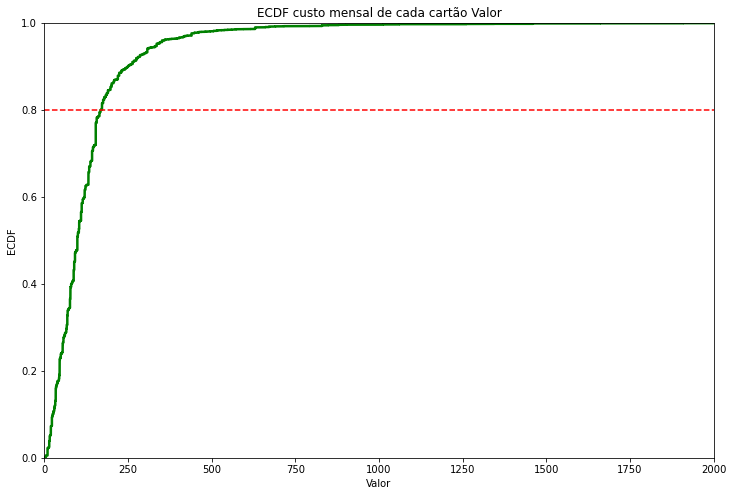

count    11128.000000
mean       129.550076
std        141.420554
min          1.000000
25%         55.000000
50%         99.000000
75%        154.000000
max       2920.000000
Name: Valor, dtype: float64

In [8]:
plu.plot_ecdf_geral(
    df=df,
    col='Valor'
)

df['Valor'].describe()

### Analisando operações | Momento do dia

In [6]:
df['dia_hora'] = pd.to_datetime(df['Dia'] + ' ' + df['Hora'])
df['hour'] = df.apply(lambda x: x['dia_hora'].hour,axis=1)
df['shift'] = pd.cut(df['hour'], bins=[0, 7, 12, 18, 24], labels=["1", "2", "3", "4"], right=False)

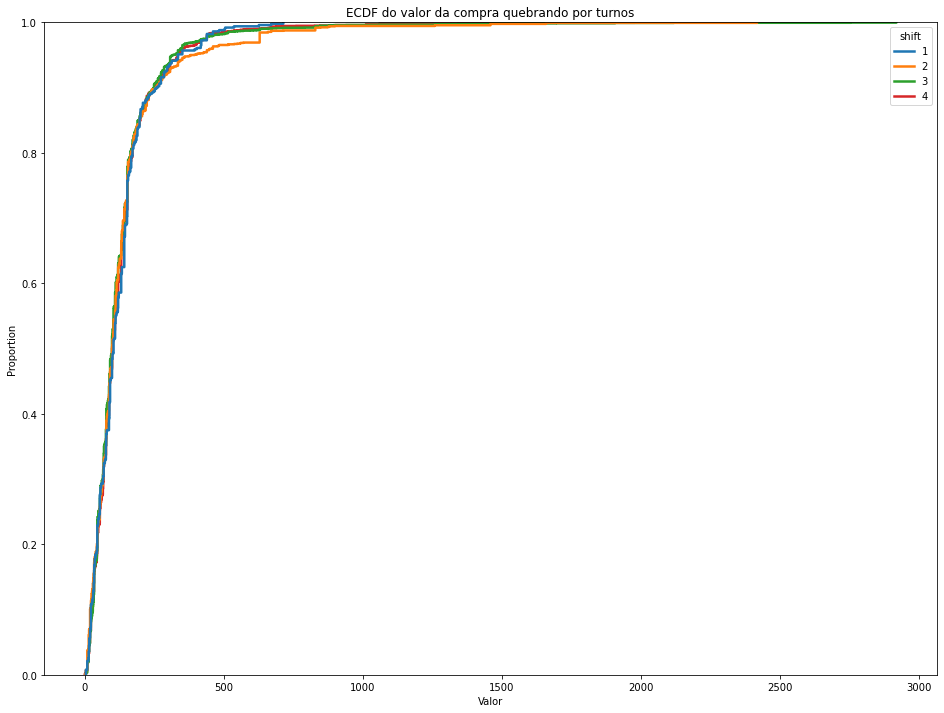

In [10]:
plu.plot_multiple_ecdf(df=df, 
                       plotting_var='Valor', 
                       hue_var='shift')

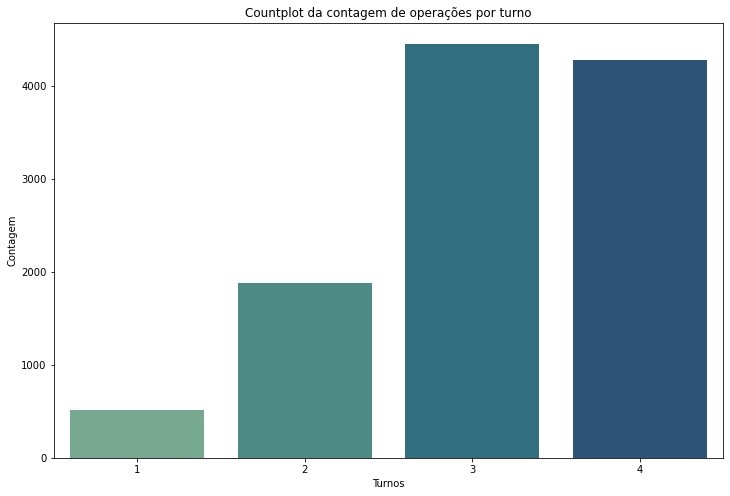

In [11]:
plu.plot_count_shift(df=df)

### Analisando operações | Dia da semana e momento do dia

In [7]:
df['weekday'] = df.apply(lambda x: x['dia_hora'].strftime("%A")[:3],axis=1)
weekday_mapping = {'Mon': 1, 
                   'Tue': 2, 
                   'Wed': 3, 
                   'Thu': 4, 
                   'Fri': 5, 
                   'Sat': 6, 
                   'Sun': 7}
df['weekday_num'] = df['weekday'].map(weekday_mapping)

In [8]:
df_grouped = df.groupby(['shift','weekday_num']).agg(
    count_operations=('Valor','count'),
    mean_valor=('Valor','mean'),
    soma_valor=('Valor','sum'),
    mediana_valor=('Valor','median')
)
df_grouped_complete = df_grouped.reset_index()\
                                .sort_values(by=['shift','weekday_num'])

df_grouped_infos = df.groupby(['shift']).agg(
    count=('Dia','count'),
    soma_total=('Valor','sum')
).reset_index()

df_grouped_complete = df_grouped_complete.merge(df_grouped_infos, on=['shift'], how='left')
df_grouped_complete['PropCount'] = df_grouped_complete.apply(lambda x: round(x['count_operations']/x['count'],2),axis=1)
df_grouped_complete['PropSoma'] = df_grouped_complete.apply(lambda x: round(x['soma_valor']/x['soma_total'],2),axis=1)

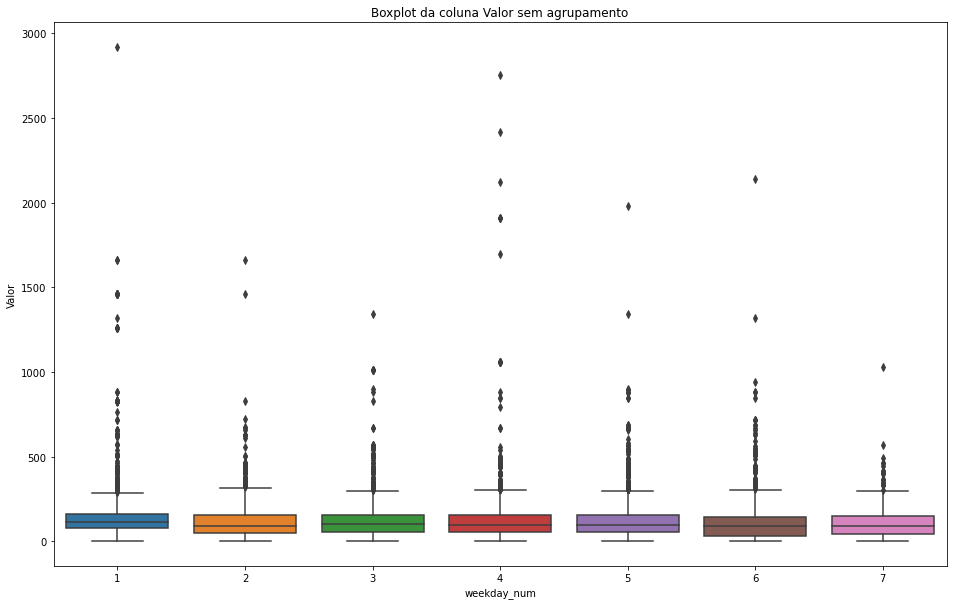

In [7]:
df_counter = df.groupby(['weekday_num']).agg(
    count_operations=('Valor','count'),
    sum_operations=('Valor','sum')
).reset_index()

plu.plot_box_plot_hue(
    df=df,
    y='Valor',
    col='weekday_num'
)

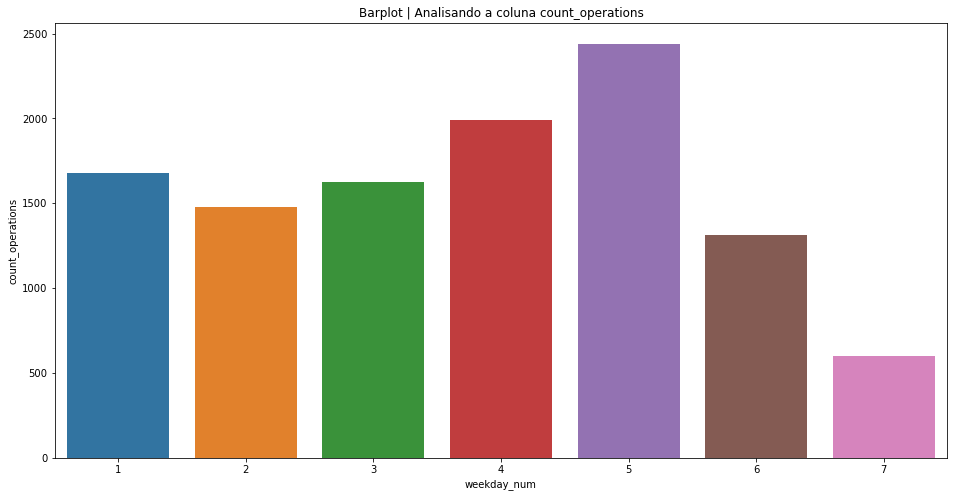

In [8]:
plu.plot_barplot_agg(df=df_counter, x='weekday_num', y='count_operations')

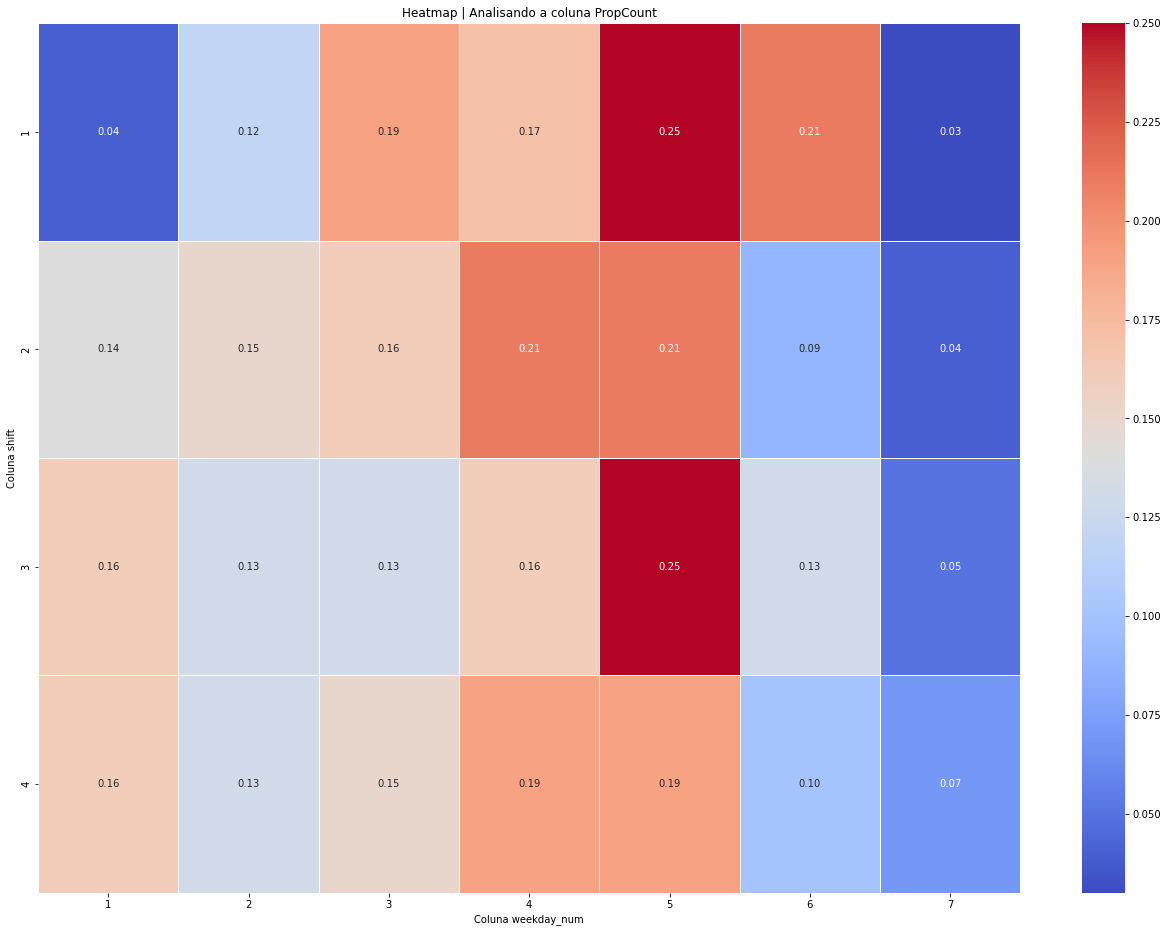

In [6]:
plu.plot_heatmap(df=df_grouped_complete, 
                 index='shift', 
                 columns='weekday_num', 
                 values='PropCount')

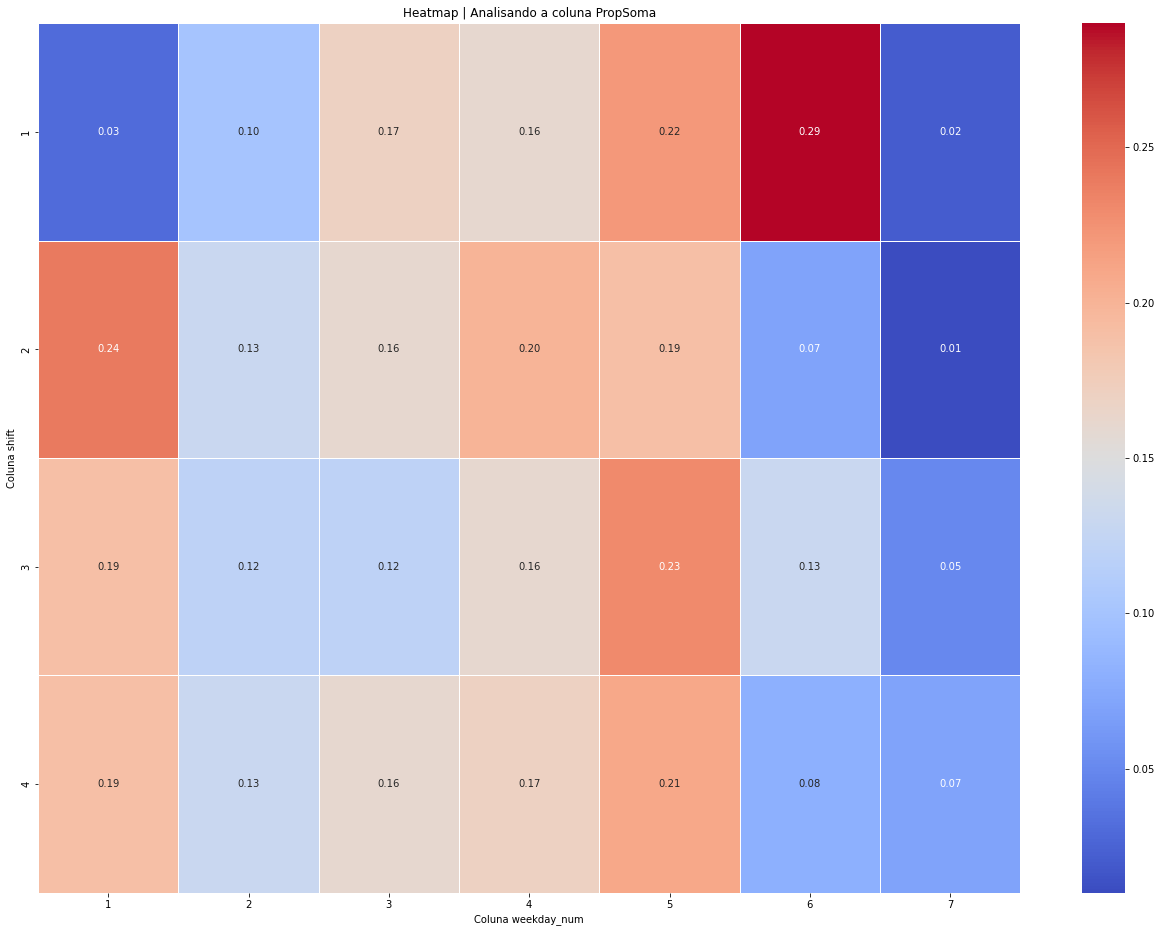

In [7]:
plu.plot_heatmap(df=df_grouped_complete, 
                 index='shift', 
                 columns='weekday_num', 
                 values='PropSoma')

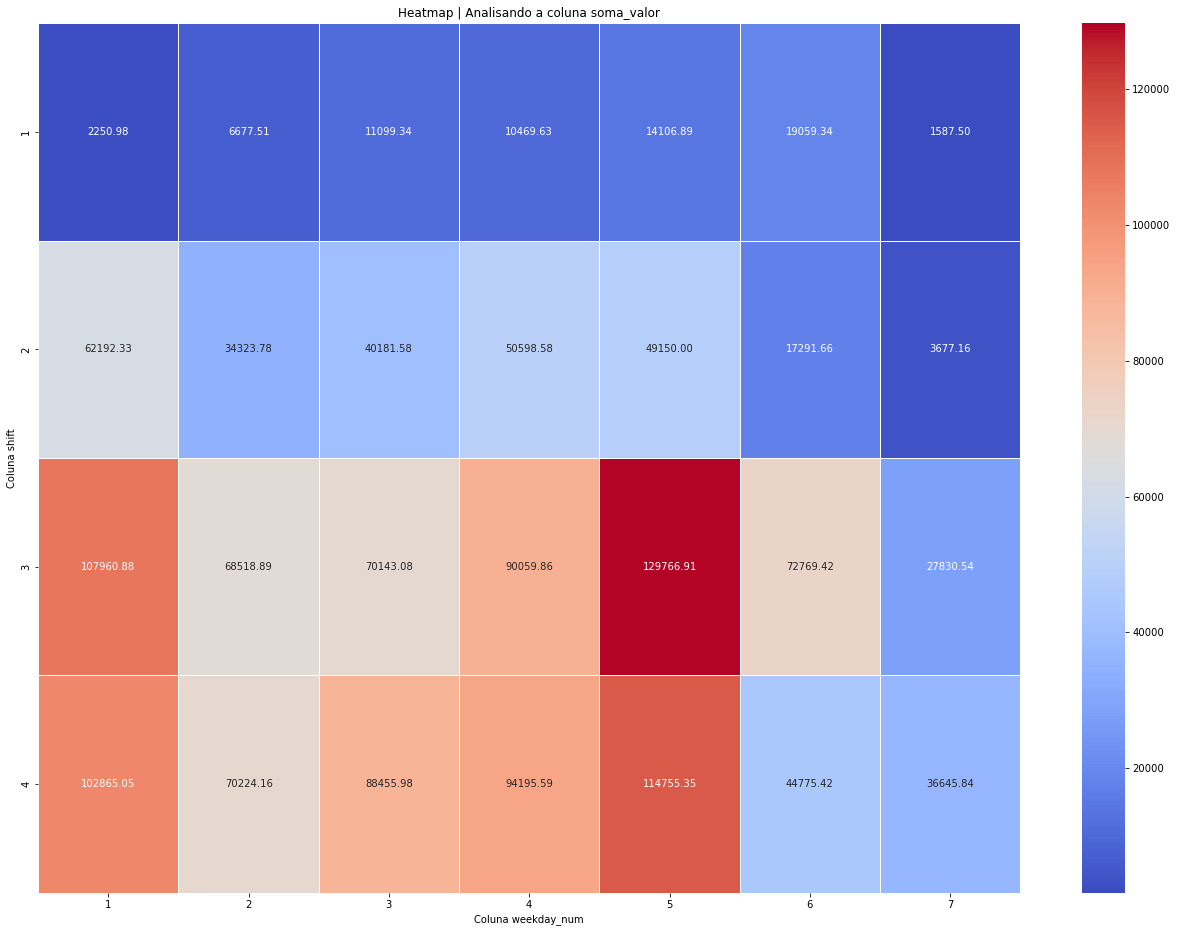

In [10]:
plu.plot_heatmap(df=df_grouped_complete, 
                 index='shift', 
                 columns='weekday_num', 
                 values='soma_valor')

### Analisando operações | Número da semana e dia da semana

In [9]:
df['week_number_month'] = df.apply(lambda x: (x['dia_hora'].day -1) // 7 + 1, axis=1)

df_grouped_week_number = df.groupby([
    'weekday_num',
    'week_number_month'
]).agg(
    count_operations=('Valor','count'),
    mean_valor=('Valor','mean'),
    soma_valor=('Valor','sum'),
    mediana_valor=('Valor','median')
)
df_grouped_week_number_complete = df_grouped_week_number.reset_index()\
                                                        .sort_values(by=['weekday_num','week_number_month'])

df_grouped_week_number_infos = df.groupby(['week_number_month']).agg(
    count=('Dia','count'),
    soma_total=('Valor','sum')
).reset_index()

df_grouped_week_number_complete_joined = df_grouped_week_number_complete.merge(df_grouped_week_number_infos, on=['week_number_month'], how='left')
df_grouped_week_number_complete_joined['PropCount'] = df_grouped_week_number_complete_joined.apply(lambda x: round(x['count_operations']/x['count'],2),axis=1)
df_grouped_week_number_complete_joined['PropSoma'] = df_grouped_week_number_complete_joined.apply(lambda x: round(x['soma_valor']/x['soma_total'],2),axis=1)
df_plot_week_number = df_grouped_week_number_complete_joined.query("~(mean_valor != mean_valor)")

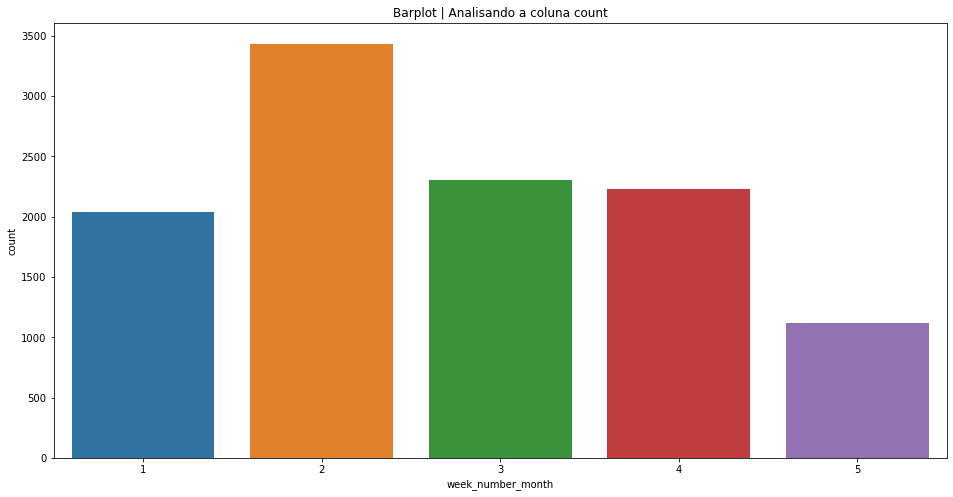

In [38]:
plu.plot_barplot_agg(df=df_grouped_week_number_infos, x='week_number_month', y='count')

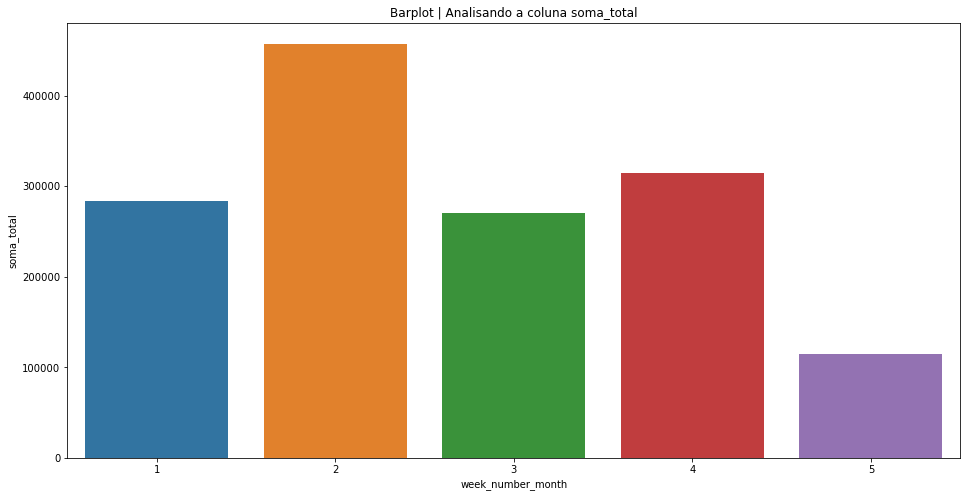

In [42]:
plu.plot_barplot_agg(df=df_grouped_week_number_infos, x='week_number_month', y='soma_total')

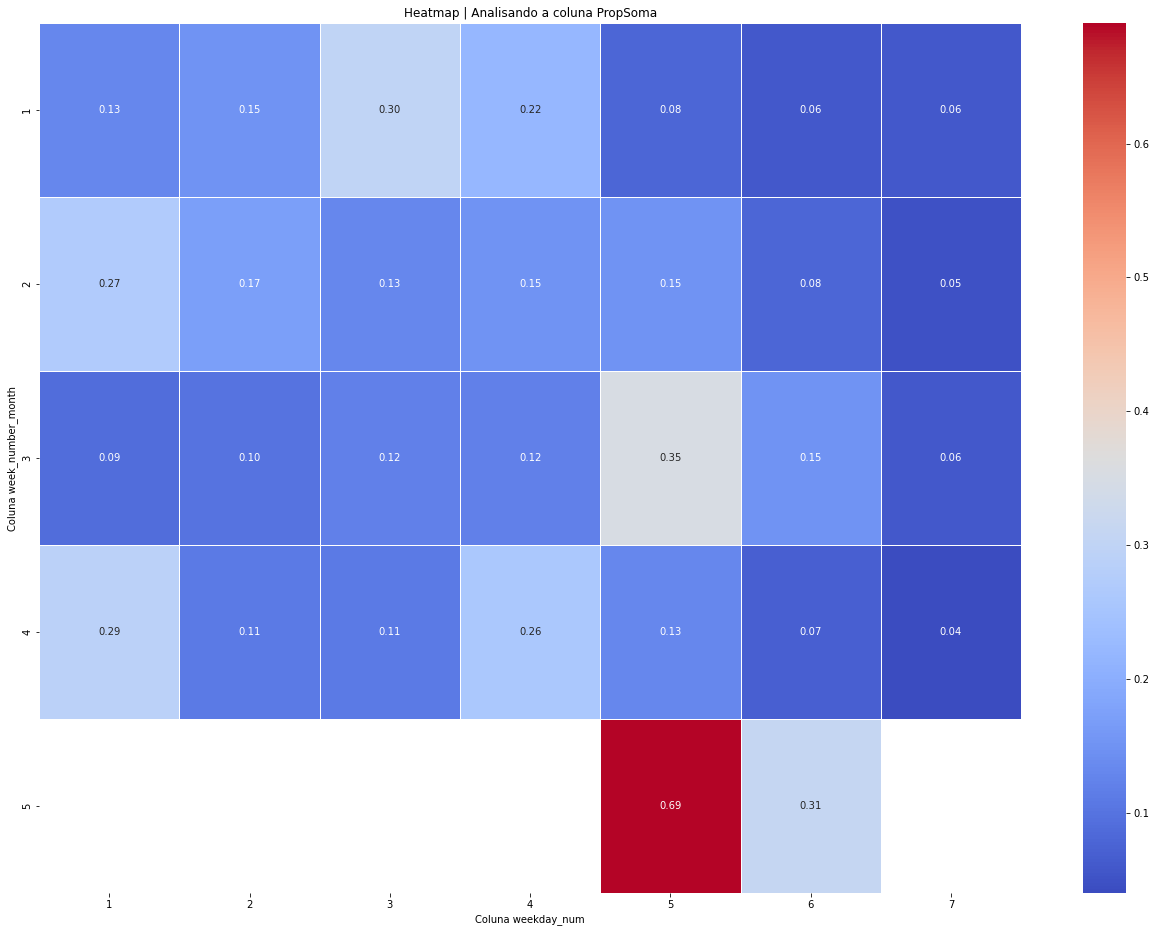

In [36]:
plu.plot_heatmap(df=df_plot_week_number .reset_index(drop=True), 
                 index='week_number_month', 
                 columns='weekday_num', 
                 values='PropSoma')

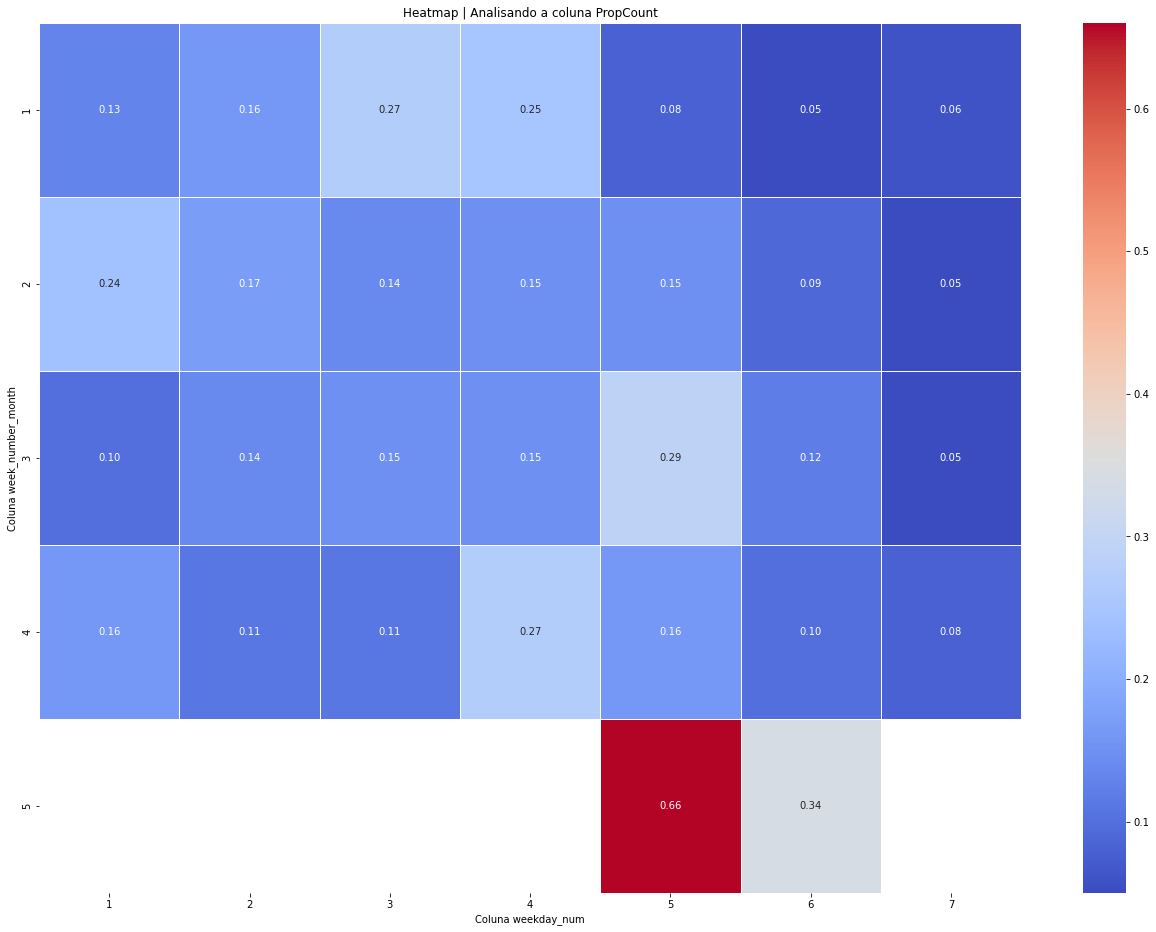

In [35]:
plu.plot_heatmap(df=df_plot_week_number .reset_index(drop=True), 
                 index='week_number_month', 
                 columns='weekday_num', 
                 values='PropCount')

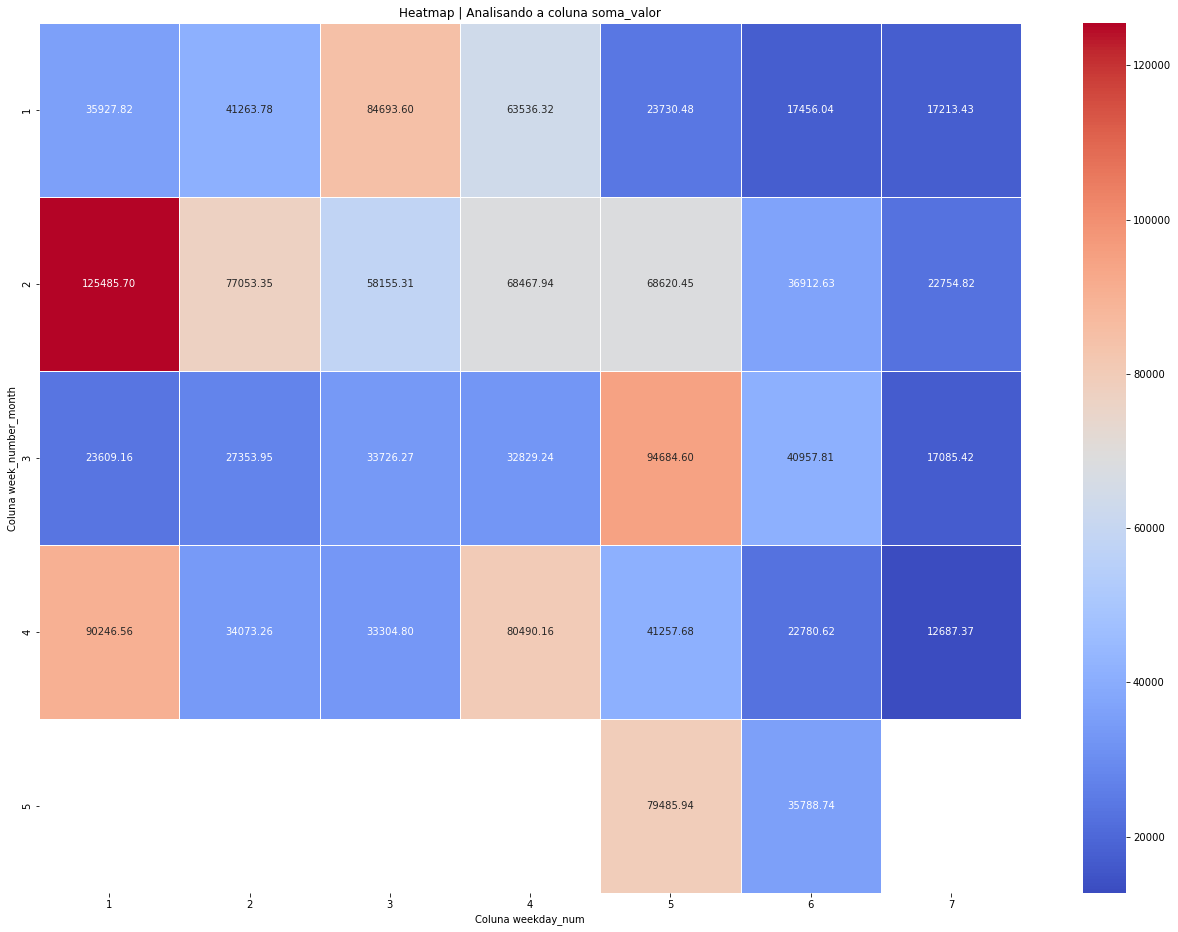

In [34]:
plu.plot_heatmap(df=df_plot_week_number .reset_index(drop=True), 
                 index='week_number_month', 
                 columns='weekday_num', 
                 values='soma_valor')

### Estatísticas do e-commerce

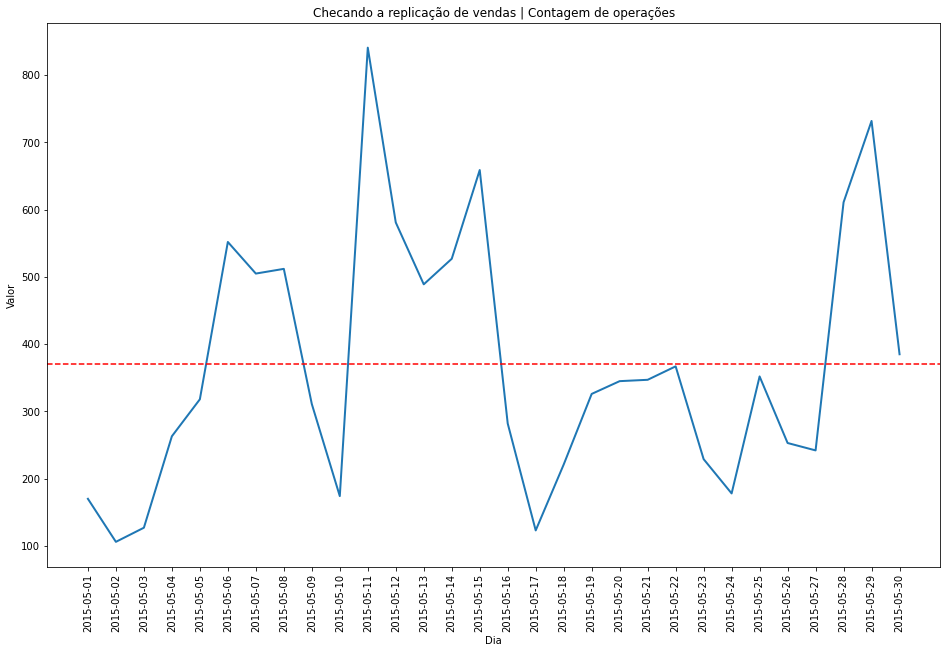

In [10]:
data = df.groupby(['Dia'])['Valor'].count().reset_index()
plu.plot_everyday_sells(df=data, y='Valor', stringer='Contagem de operações')

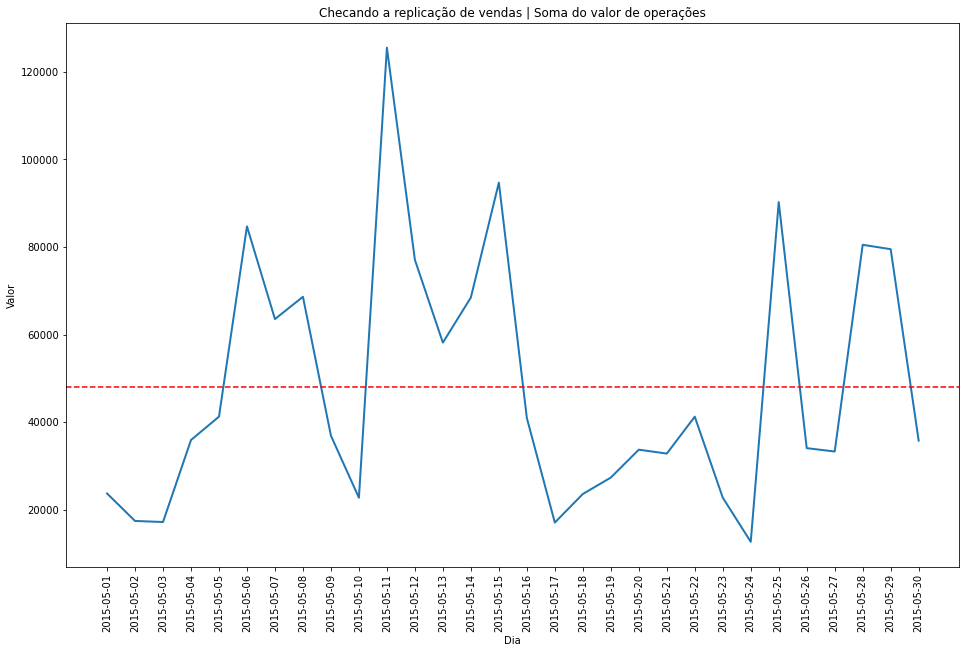

In [11]:
data = df.groupby(['Dia'])['Valor'].sum().reset_index()
plu.plot_everyday_sells(df=data, y='Valor', stringer='Soma do valor de operações')